In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.preprocessing import scale
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns
# from pysankey import sankey

%matplotlib inline

## Load annotation table

In [11]:
MAXSIZE = 100

# Read table
my_cols = [i for i in range(MAXSIZE)]
df = pd.read_csv("data/CCF/template/Mouse.csv", names=my_cols, engine='python', 
                 skiprows=[0], 
                 index_col=[1], 
                 skipinitialspace=True)
df = df.drop([0,3,4,5,6,7,8], axis=1)
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i,j] is None:
            df.iloc[i,j] = np.nan
df.columns = ["Abbrevation"]+["Level_"+str(i) for i in range(1, df.shape[1])]
df_isnull = df.isnull()

# Get levels of each row 
level = []
description = []
MAXLEVEL = 0
for i in range(len(df)):
    for j in range(1, df.shape[1]):
        if not df_isnull.iloc[i,j]:
            level.append(j)
            description.append(df.iloc[i,j])
            break
MAXLEVEL = np.max(level)
level = pd.DataFrame({'level':level, 'Abbrevation':df.Abbrevation.tolist() ,'Description':description},
                      index=df.index)

# Drop redundant columns
df = df.iloc[:, :(MAXLEVEL+2)]  # The last column will contain only NaN
df_isnull = df.isnull()

In [21]:
df_fill = df.copy()
for i in range(1, df.shape[1]):
# for i in range(1, 2):
    cur_region = None
    for j in range(df.shape[0]):
        if not df_isnull.iloc[j,i]:
            cur_region = df.iloc[j,i]
            cur_level = level.loc[df.index[j],'level']
            print(j, cur_region, cur_level)
        elif (not cur_region is None) & (cur_level<level.loc[df.index[j],'level']):
                df_fill.iloc[j,i] = cur_region

# Check valid
df_fill_isnull = df_fill.isnull()
for i in range(len(df)):
    for j in range(1, df.shape[1]):
        if df_fill_isnull.iloc[i,j]:
            if(level.iloc[i,0] != (j-1)):
                print(i)
            break                

def cut_by_level(df_fill, level=None):
    '''
    Return the deepest levels possible of a taxonomy tree
    '''
    if level is None:
        level = df_fill.shape[1]-1
    # 1. Remove terms deeper than the level threshold
    df_fill_isnull = df_fill.isnull()
    drop_list = []
    for i in range(df_fill.shape[0]):
        if not df_fill_isnull.iloc[i, level+1]:
            drop_list.append(df_fill.index[i])
    df_fill = df_fill.drop(drop_list)
    df_fill_isnull = df_fill.isnull()
    # 2. Remove internal terms
    drop_list = []
    for i in range(df_fill.shape[0]):
        for j in range(1, level+1):
            if df_fill_isnull.iloc[i,j]: 
                check_column = j-1
                check_name = df_fill.iloc[i, check_column]
                if df_fill.iloc[:, check_column].value_counts()[check_name] > 1:  # the current term is the parent node of some other terms
                    drop_list.append(df_fill.index[i])
                break
    df_fill = df_fill.drop(drop_list)
    return df_fill

0 root 1
1 Basic cell groups and regions 2
1101 fiber tracts 2
1292 ventricular systems 2
1304 grooves 2
1326 retina 2
2 Cerebrum 3
639 Brain stem 3
1014 Cerebellum 3
1102 cranial nerves 3
1171 cerebellum related fiber tracts 3
1189 supra-callosal cerebral white matter 3
1190 lateral forebrain bundle system 3
1218 extrapyramidal fiber systems 3
1238 medial forebrain bundle system 3
1293 lateral ventricle 3
1298 interventricular foramen 3
1299 third ventricle 3
1300 cerebral aqueduct 3
1301 fourth ventricle 3
1303 central canal, spinal cord/medulla 3
1305 grooves of the cerebral cortex 3
1310 grooves of the cerebellar cortex 3
1325 Interpeduncular fossa 3
3 Cerebral cortex 4
570 Cerebral nuclei 4
640 Interbrain 4
806 Midbrain 4
882 Hindbrain 4
1015 Cerebellar cortex 4
1096 Cerebellar nuclei 4
1103 terminal nerve 4
1104 vomeronasal nerve 4
1105 olfactory nerve 4
1112 optic nerve 4
1119 oculomotor nerve 4
1122 trochlear nerve 4
1124 abducens nerve 4
1125 trigeminal nerve 4
1130 facial ner

6 Frontal pole, cerebral cortex 7
12 Somatomotor areas 7
30 Somatosensory areas 7
107 Gustatory areas 7
114 Visceral area 7
121 Auditory areas 7
157 Visual areas 7
220 Anterior cingulate area 7
238 Prelimbic area 7
245 Infralimbic area 7
252 Orbital area 7
278 Agranular insular area 7
297 Retrosplenial area 7
339 Posterior parietal association areas 7
360 Temporal association areas 7
367 Perirhinal area 7
373 Ectorhinal area 7
380 Main olfactory bulb 7
386 Accessory olfactory bulb 7
390 Anterior olfactory nucleus 7
398 Taenia tecta 7
410 Dorsal peduncular area 7
416 Piriform area 7
421 Nucleus of the lateral olfactory tract 7
426 Cortical amygdalar area 7
444 Piriform-amygdalar area 7
449 Postpiriform transition area 7
455 Hippocampal region 7
492 Retrohippocampal region 7
559 Endopiriform nucleus, dorsal part 7
560 Endopiriform nucleus, ventral part 7
563 Basolateral amygdalar nucleus, anterior part 7
564 Basolateral amygdalar nucleus, posterior part 7
565 Basolateral amygdalar nucleu

255 Orbital area, layer 5 8
256 Orbital area, layer 6a 8
257 Orbital area, layer 6b 8
258 Orbital area, lateral part 8
264 Orbital area, medial part 8
271 Orbital area, ventral part 8
272 Orbital area, ventrolateral part 8
279 Agranular insular area, dorsal part 8
285 Agranular insular area, posterior part 8
291 Agranular insular area, ventral part 8
298 Retrosplenial area, lateral agranular part 8
325 Retrosplenial area, dorsal part 8
332 Retrosplenial area, ventral part 8
340 Posterior parietal association areas, layer 1 8
341 Posterior parietal association areas, layer 2/3 8
342 Posterior parietal association areas, layer 4 8
343 Posterior parietal association areas, layer 5 8
344 Posterior parietal association areas, layer 6a 8
345 Posterior parietal association areas, layer 6b 8
346 Anterior area 8
353 Rostrolateral visual area 8
361 Temporal association areas, layer 1 8
362 Temporal association areas, layer 2/3 8
363 Temporal association areas, layer 4 8
364 Temporal association 

195 Posterolateral visual area, layer 4 9
196 Posterolateral visual area, layer 5 9
197 Posterolateral visual area, layer 6a 9
198 Posterolateral visual area, layer 6b 9
200 posteromedial visual area, layer 1 9
201 posteromedial visual area, layer 2/3 9
202 posteromedial visual area, layer 4 9
203 posteromedial visual area, layer 5 9
204 posteromedial visual area, layer 6a 9
205 posteromedial visual area, layer 6b 9
207 Laterointermediate area, layer 1 9
208 Laterointermediate area, layer 2/3 9
209 Laterointermediate area, layer 4 9
210 Laterointermediate area, layer 5 9
211 Laterointermediate area, layer 6a 9
212 Laterointermediate area, layer 6b 9
214 Postrhinal area, layer 1 9
215 Postrhinal area, layer 2/3 9
216 Postrhinal area, layer 4 9
217 Postrhinal area, layer 5 9
218 Postrhinal area, layer 6a 9
219 Postrhinal area, layer 6b 9
227 Anterior cingulate area, dorsal part, layer 1 9
228 Anterior cingulate area, dorsal part, layer 2/3 9
229 Anterior cingulate area, dorsal part, laye

61 Rostrolateral lateral visual area, layer 4 11
62 Rostrolateral lateral visual area,layer 5 11
63 Rostrolateral lateral visual area, layer 6a 11
64 Rostrolateral lateral visual area, layer 6b 11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
2

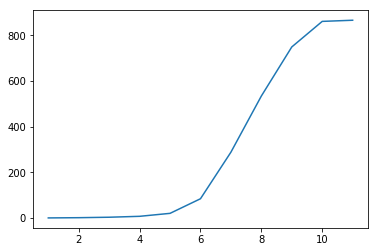

In [22]:
region_ct = []
for i in range(1, MAXLEVEL+1):
    tp = cut_by_level(df_fill, i)
    tp = tp[tp["Level_2"]=="Basic cell groups and regions"]
    tp = level.loc[tp.index]
    region_ct.append(len(tp))
    
plt.plot(np.arange(1, MAXLEVEL+1), region_ct)

In [23]:
brain_regions = cut_by_level(df_fill, 8)
brain_regions = brain_regions[brain_regions["Level_2"]=="Basic cell groups and regions"]
brain_levels = level.loc[brain_regions.index]

print(brain_levels.shape)
brain_levels.head()

(534, 3)


,Abbrevation,Description,level
1,,,
68,FRP1,"Frontal pole, layer 1",8
667,FRP2/3,"Frontal pole, layer 2/3",8
526157192,FRP5,"Frontal pole, layer 5",8
526157196,FRP6a,"Frontal pole, layer 6a",8
526322264,FRP6b,"Frontal pole, layer 6b",8


## Load neuron distribution

In [24]:
dendrite_location = pd.DataFrame(columns=brain_levels.index)
axon_location = pd.DataFrame(columns=brain_levels.index)
hemi_location = pd.DataFrame(columns=['hemisphere'])
ncol = brain_levels.shape[0]

data_dir = "./data/CCF/mapped/location/"
standard_columns = ['Unnamed: 0', '(basal) dendrite', 'axon', 'dataset', 'hemisphere_id', 'structure_id']

for input_table in os.listdir(data_dir):
    if input_table.endswith(".csv"):
        input_table = os.path.join(data_dir, input_table)
    else:
        continue
    df = pd.read_csv(input_table)
    
    # Check column names 
    check_columns = True
    if df.shape[1] != len(standard_columns):
        print(input_table)
        continue
    for i,col in enumerate(df.columns.tolist()):
        if col != standard_columns[i]:
            print(input_table)
            check_columns = False
            break
    if not check_columns:
        continue
        
    # Load table  
    df = pd.read_csv(input_table, index_col=[5])
    df = df.drop([df.columns[0]], axis=1)
    df = df.fillna(0)
    cell_id = '_'.join(df.dataset.iloc[0].split('_')[:2])
    hemi_id = df.hemisphere_id.iloc[0]
    df.dataset = cell_id

    # Remove unwanted rows
    lab = []
    for i in range(len(df)):
        if not df.index[i] in brain_levels.index.tolist():
            lab.append(df.index[i])
    df = df.drop(lab)

    # Dendrite
    tp = pd.DataFrame(np.zeros((1, ncol)), columns=brain_levels.index, index=[cell_id])
    tp[df.index] = df["(basal) dendrite"].tolist()
    dendrite_location = pd.concat([dendrite_location, tp])
    # Axon
    tp = pd.DataFrame(np.zeros((1, ncol)), columns=brain_levels.index, index=[cell_id])
    tp[df.index] = df["axon"].tolist()
    axon_location = pd.concat([axon_location, tp])
    # hemisphere
    tp = pd.DataFrame([hemi_id], columns=['hemisphere'], index=[cell_id])
    hemi_location = pd.concat([hemi_location, tp])

dendrite_location.columns = brain_levels.loc[dendrite_location.columns, 'Description']
axon_location.columns = brain_levels.loc[axon_location.columns, 'Description']

./data/CCF/mapped/location/17302_085_HGD_LijLiu_07282018.ano.eswc.csv
./data/CCF/mapped/location/17302_091_SYY_WW_ZSJ_08032018.ano.eswc.csv
./data/CCF/mapped/location/17302_051_ChenXP_SYY_07312018.ano.eswc.csv
./data/CCF/mapped/location/17302_071_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_069_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_072_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_061_LjL_09072018.ano.eswc.csv
./data/CCF/mapped/location/17302_068_LiuAn_LijLiu_05152018.ano.swc.ano.swc.csv
./data/CCF/mapped/location/17302_073_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_084_liuan_LijLiu_06112018.ano.swc.csv
./data/CCF/mapped/location/17302_045_LjLiu_05132018.ano.eswc.csv
./data/CCF/mapped/location/17302_058_ChenXP_SYY_07312018.ano.eswc.csv
./data/CCF/mapped/location/17302_070_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_031_HGD_LijLiu_07062018.ano.eswc.csv
./data/CCF/mapped/location/17302_067_LiuAn

In [25]:
pickle.dump([dendrite_location, axon_location, hemi_location, brain_levels, brain_regions],
           open("data/CCF/mapped/location/17302_location.pickle", 'wb'))

location_sum = pd.DataFrame(np.sum(axon_location + dendrite_location, axis=0)).sort_values(0, ascending=False)
lab = location_sum[location_sum[0]>0].index

writer = pd.ExcelWriter('Table/17302_location.xlsx')
dendrite_location[lab].to_excel(writer,'Dendrite')
axon_location[lab].to_excel(writer,'Axon')
hemi_location.to_excel(writer,'Hemisphere')
brain_levels.to_excel(writer, 'Brain_regions')
writer.save()

## Examine brain region assignment

Regions used:	 16


,0
Description,
Caudoputamen,110576.984332
Primary visual area,21532.186581
Primary somatosensory area,20441.456322
"Substantia nigra, reticular part",15852.497528
Primary auditory area,7705.090635
"Gustatory areas, layer 6a",6892.678766
Supplemental somatosensory area,6759.121775
Claustrum,6502.433237
"Orbital area, ventrolateral part",6242.298202


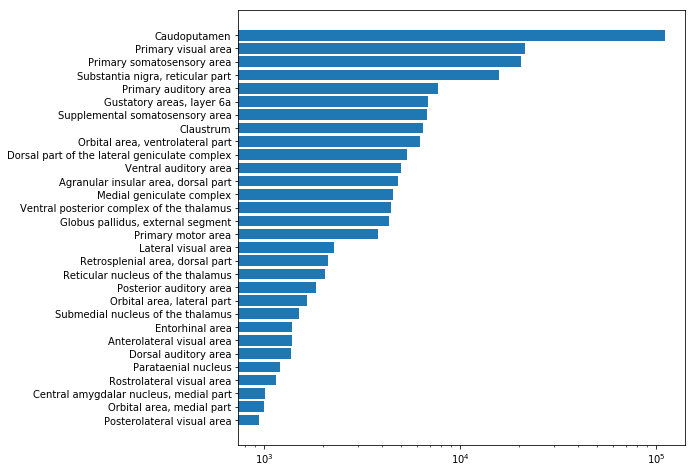

In [26]:
features = pd.read_excel("Table/Global_features.xlsx")
features['Type'] = pd.Categorical(features['Type'])   

location_all = axon_location + dendrite_location
# location = dendrite_location
use_cells = sorted(list(set(features.index).intersection(set(location_all.index))))

features = features.loc[use_cells]
location = location_all.loc[use_cells]
# location.columns = brain_levels.loc[location.columns, "Description"]


# Cell types
celltypes = pd.DataFrame(features['Type'])
u_celltypes = list(set(celltypes['Type']))

assert len(u_celltypes)<10
celltypes_pal = ['C'+str(i) for i in range(len(u_celltypes))]
celltypes_lut = dict(zip(sorted(u_celltypes), celltypes_pal))
celltypes_col = []
for tp in celltypes['Type'].tolist():
    celltypes_col.append(celltypes_lut[tp])


location_sum = pd.DataFrame(np.sum(location, axis=0)).sort_values(0, ascending=False)

plt.figure(figsize=(8,8))
n_disp = 30
plt.barh(np.linspace(n_disp,1,n_disp), location_sum.iloc[:n_disp, 0], tick_label=location_sum.index[:n_disp])
plt.xscale('log')

lab = [i for i in range(location.shape[1]) if location.iloc[:,i].sum()>np.percentile(location_sum[0], 97)]

print("Regions used:\t", len(lab))
location = location.iloc[:, lab]
location_sum.iloc[0:n_disp, :]

Text(0,0.5,'distance (Ward)')

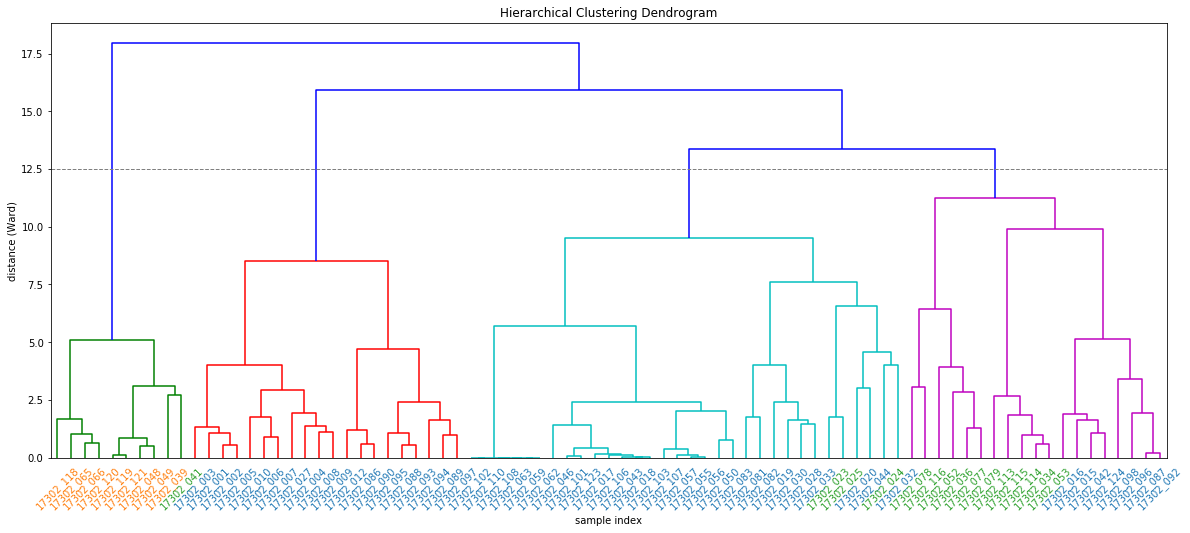

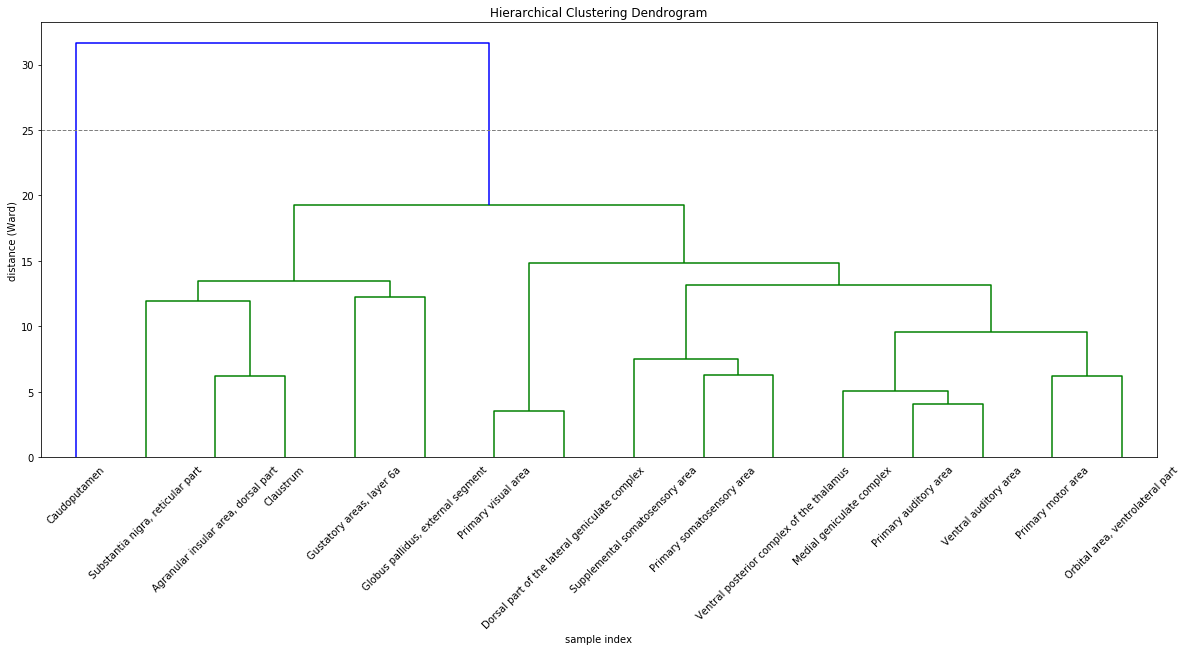

In [33]:
df = pd.DataFrame(scale(np.log10(location+1), axis=1), columns=location.columns, index=location.index)

# Plot 1: Hierarchical clustering (by samples)

Z_sample = linkage(df, 'ward')

thres_sample = 12.5
fig, ax = plt.subplots(1,1,figsize=(20,8))
d = dendrogram(Z_sample, labels=df.index, leaf_rotation=45, leaf_font_size=10,
               color_threshold=thres_sample, orientation="top",
              )
plt.axhline(y=thres_sample, c='grey', lw=1, linestyle='dashed')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
my_color=celltypes.loc[d['ivl'], 'Type'].cat.codes
 
# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    lbl.set_color(celltypes_pal[my_color[num]])
    
# Plot 2: Hierarchical clustering (by features)

Z_feature = linkage(df.transpose(), method = 'ward', metric='euclidean')

thres_feature = 25
fig, ax = plt.subplots(1,1,figsize=(20,8))
d = dendrogram(Z_feature, labels=df.columns, leaf_rotation=45, leaf_font_size=10,
               color_threshold=thres_feature, orientation="top",
              )
plt.axhline(y=thres_feature, c='grey', lw=1, linestyle='dashed')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

In [34]:
clusters = pd.DataFrame({'cluster':fcluster(Z_sample, thres_sample, criterion="distance")}, index=df.index)
clusters.to_excel("Table/R_cluster.xlsx")

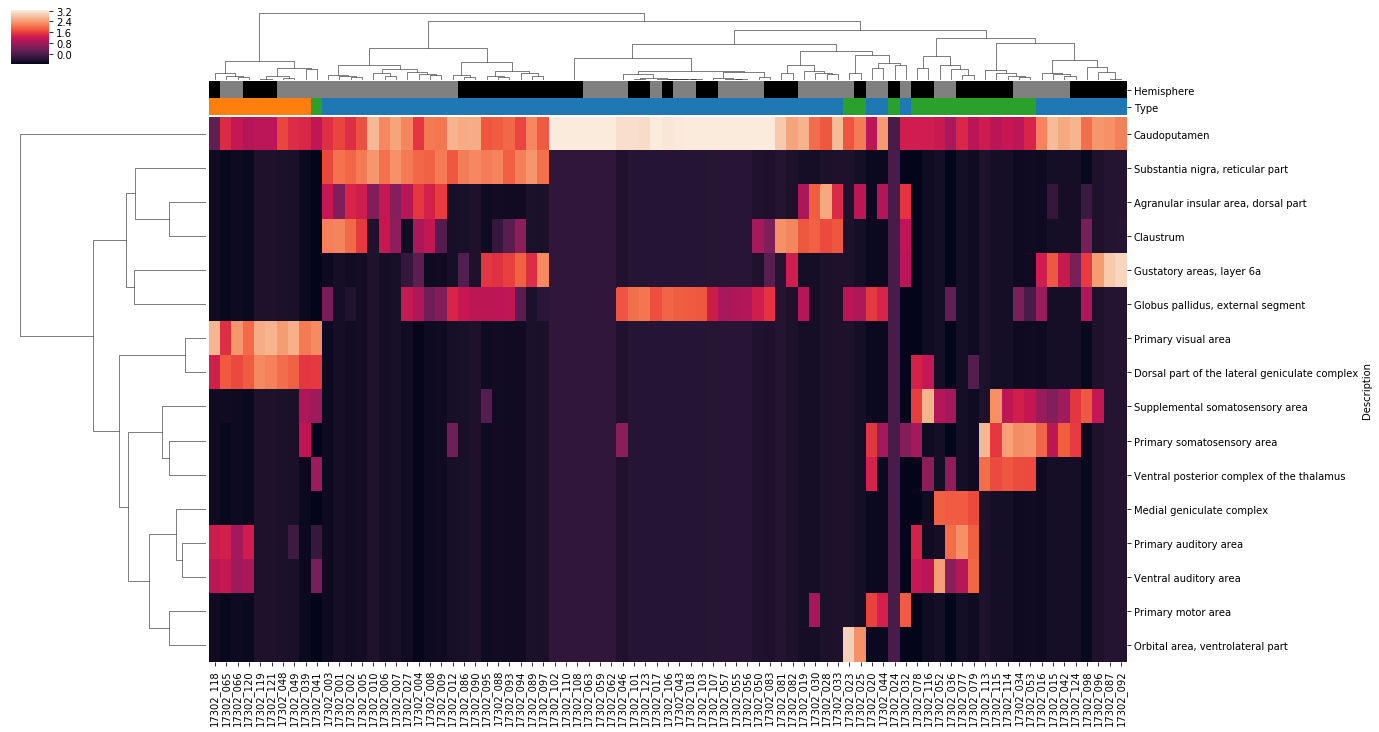

In [29]:
hemi_lut = {1:'grey', 2:'black'}
hemi_col = [hemi_lut[i] for i in hemi_location.loc[df.index, 'hemisphere'].tolist()]
col_colors = pd.DataFrame({'Type':celltypes_col, 'Hemisphere':hemi_col}, index=df.index)

g = sns.clustermap(df.transpose(), linewidths=0.0, linecolor='white',
                   row_linkage=Z_feature,
                   col_linkage=Z_sample,
                   col_colors=col_colors,
                   vmax=np.percentile(df, 99),
                   vmin=np.percentile(df, 1),
                   annot=False, figsize=(20,12))
g.savefig("Figure/Heatmap_Location_AllNeurons.pdf")

## Compare feature cluster and region cluster

In [ ]:
rcl = pd.read_excel("Table/R_cluster.xlsx")
fcl = pd.read_excel("Table/F_cluster.xlsx")+1

s1 = set(rcl.index.tolist())
s2 = set(fcl.index.tolist())
lab = list(s1.intersection(s2))
print("Number of cells:\t", len(lab))

rcl = rcl.loc[lab]
fcl = fcl.loc[lab]